# Load libraries

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from pathlib import Path

# Functions

In [3]:
def get_mean_std(da):
    return da.mean(['time','lon'], keep_attrs = True), da.std('time', keep_attrs = True)


def preprocess(da):
    da = da.set_coords(['lev','lon','lat'])
    da = da.rename({'levs': 'lev', 'lats': 'lat', 'lons': 'lon'})
    da['lev'].attrs['long_name'] = 'altitude'
    da['lat'].attrs['long_name'] = 'latitude'
    da['lon'].attrs['long_name'] = 'longitude'
    
    return da

def ttest_ind_wrap(a,b):
    _, pv = ttest_ind(a,b, axis = 0, equal_var = False)
    return pv

# Get list of input files

In [4]:
root_path = Path('/projekt5/hochatm/muam_mstober/')
in_folders = [f for f in root_path.iterdir() if f.is_dir()] # get all folder in root_path

In [5]:
# define ENSO years
el_year_ls = [1983,1992,1998,2003,2010]
la_year_ls = [1989,1999,2000,2008,2013]

sel_month = 'Jan' 
# get El Nino and La Nina directories
el_in_folders = list(filter(lambda x: str(x)[-8:] in [f'{year}_{sel_month}' for year in el_year_ls], in_folders)) 
la_in_folders = list(filter(lambda x: str(x)[-8:] in [f'{year}_{sel_month}' for year in la_year_ls], in_folders))
# and particular input files
add_nc_suffix = lambda x: x / 'nc' / 'muam_Jan330.nc'
el_in_files = list(map(add_nc_suffix, el_in_folders))
la_in_files = list(map(add_nc_suffix, la_in_folders))

# Load data

In [6]:
sel_var = 'tem'
# concatenate files along 'year_ens' dimension
ds_el = xr.open_mfdataset(el_in_files, concat_dim = 'year_ens', parallel = True, combine='nested', preprocess=preprocess)
ds_la = xr.open_mfdataset(la_in_files, concat_dim = 'year_ens', parallel = True, combine='nested', preprocess=preprocess)
# mean and std calculation
mean_el, std_el = get_mean_std(ds_el[sel_var])
mean_la, std_la = get_mean_std(ds_la[sel_var])

# P-values calculation

In [7]:
# vectorized ttest_ind calculation
da_pv = xr.apply_ufunc(ttest_ind_wrap, mean_el, mean_la, \
               vectorize = True, dask = 'allowed', \
               input_core_dims=[['year_ens'],['year_ens']], \
               output_core_dims=[[]])

# Plotting

Text(0.5, 1.0, 'Zonally avarage temperature diff. between El-Nino and La-Nina in Jan')

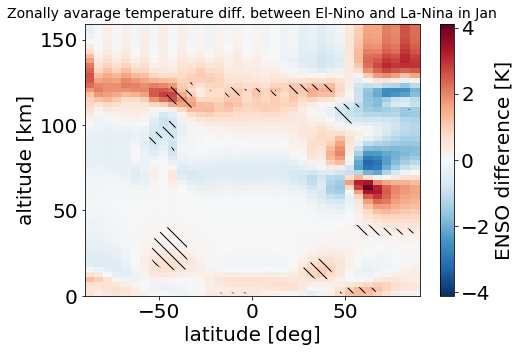

In [10]:
diff = mean_el-mean_la
diff.attrs['units'] = 'K'
diff.attrs['long_name'] = 'ENSO difference'

plt.rcParams.update({'font.size': 20})
p = diff.mean('year_ens', keep_attrs = True).plot(size = 5)
# hatching to display pvalues smaller than 0.05 and 0.01, respectively
ax = p.axes
plot_kwargs2 = dict(levels = [0,0.05], hatches = ['\\\\',None], colors='none', add_colorbar=False)
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
plot_kwargs2['levels'] = [0,0.01]
plot_kwargs2['hatches'] = ['////',None]
da_pv.plot.contourf(ax = ax, **plot_kwargs2)
ax.set_title(f'Zonally avarage temperature diff. between El-Nino and La-Nina in {sel_month}', fontsize = 14)